# **Game Recommendation System**

# **DATA Initialization**


In [ ]:
# Reproducibility
import random, numpy as _np
random.seed(42)
_np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')


## **Data Inspection 🔍**

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score


In [ ]:

# نقرأ الملف
df = pd.read_csv("/content/steamgames_100k_rows.csv")

# نعرض أول 5 أسطر للتأكد
# NOTE: Sampling a fraction of the data for prototyping. Remove for full run.
df = df.sample(frac=0.2, random_state=42)

df.head().T

,75721,80184,19864,76699,92991
UserID,9181665.0,11531502.0,1299092.0,13862042.0,6282199.0
GameName,FOR HONOR™,Grand Theft Auto V,No Man's Sky,Grand Theft Auto V,Grand Theft Auto V
Hours,1.0,1.0,249.0,3.4,1.0
Behavior,purchase,purchase,play,play,purchase
Categories,Multi-player,"Single-player, Multi-player","Single-player, Multi-player",Not Classified,Not Classified
Genres,['Action'],"['Action', 'Adventure']","['Adventure', 'Simulation']",['Strategy'],"['Action', 'Adventure']"
is_recommended,True,True,True,False,False


In [ ]:
print(df.columns)

Index(['UserID', 'GameName', 'Hours', 'Behavior', 'Categories', 'Genres',
       'is_recommended'],
      dtype='object')


In [ ]:
print('🧾INFO:')
df.info()

print('\n📐SHAPE:',df.shape)

print('\n🚫NULLS:')
print(df.isna().sum())

print('\n❗❗DUPLICATES:',df.duplicated().sum())

🧾INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 75721 to 42410
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          20000 non-null  float64
 1   GameName        20000 non-null  object 
 2   Hours           19998 non-null  float64
 3   Behavior        19998 non-null  object 
 4   Categories      20000 non-null  object 
 5   Genres          20000 non-null  object 
 6   is_recommended  20000 non-null  bool   
dtypes: bool(1), float64(2), object(4)
memory usage: 1.1+ MB

📐SHAPE: (20000, 7)

🚫NULLS:
UserID            0
GameName          0
Hours             2
Behavior          2
Categories        0
Genres            0
is_recommended    0
dtype: int64

❗❗DUPLICATES: 54


## **Data Cleaning 🧹**

In [ ]:
df.drop_duplicates(inplace=True)
print(df.shape)

(19946, 7)


In [ ]:
# Replace missing values in 'Hours' with the mean
df['Hours'].fillna(df['Hours'].mean(), inplace=True)

# Replace missing values in 'Behavior' with the mode
df['Behavior'].fillna(df['Behavior'].mode()[0], inplace=True)

# Now you can check for null values again to confirm they are all gone
print(df.isnull().sum())

UserID            0
GameName          0
Hours             0
Behavior          0
Categories        0
Genres            0
is_recommended    0
dtype: int64


/tmp/ipython-input-682318645.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Hours'].fillna(df['Hours'].mean(), inplace=True)
/tmp/ipython-input-682318645.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
print('🧾INFO:')
df.info()
print('\n🔍HEAD:')
df.head()

🧾INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 19946 entries, 75721 to 42410
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          19946 non-null  float64
 1   GameName        19946 non-null  object 
 2   Hours           19946 non-null  float64
 3   Behavior        19946 non-null  object 
 4   Categories      19946 non-null  object 
 5   Genres          19946 non-null  object 
 6   is_recommended  19946 non-null  bool   
dtypes: bool(1), float64(2), object(4)
memory usage: 1.1+ MB

🔍HEAD:


,UserID,GameName,Hours,Behavior,Categories,Genres,is_recommended
75721,9181665.0,FOR HONOR™,1.0,purchase,Multi-player,['Action'],True
80184,11531502.0,Grand Theft Auto V,1.0,purchase,"Single-player, Multi-player","['Action', 'Adventure']",True
19864,1299092.0,No Man's Sky,249.0,play,"Single-player, Multi-player","['Adventure', 'Simulation']",True
76699,13862042.0,Grand Theft Auto V,3.4,play,Not Classified,['Strategy'],False
92991,6282199.0,Grand Theft Auto V,1.0,purchase,Not Classified,"['Action', 'Adventure']",False


In [ ]:
# checking for unwanted values (any other behaviors get dropped)
df = df[df["Behavior"].isin(["play", "purchase"])].copy()
# object to string
df["GameName"] = df["GameName"].astype("string")
df["Behavior"] = df["Behavior"].astype("string")
# Convert UserID to a nullable integer type to handle potential nulls
df['UserID'] = df['UserID'].astype('Int64')
# Convert Categories and Genres to the 'category' data type for memory efficiency
df['Categories'] = df['Categories'].astype('category')
df['Genres'] = df['Genres'].astype('category')
# Check the DataFrame info after the changes
print('🧾New INFO:')
df.info()


🧾New INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 19946 entries, 75721 to 42410
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   UserID          19946 non-null  Int64   
 1   GameName        19946 non-null  string  
 2   Hours           19946 non-null  float64 
 3   Behavior        19946 non-null  string  
 4   Categories      19946 non-null  category
 5   Genres          19946 non-null  category
 6   is_recommended  19946 non-null  bool    
dtypes: Int64(1), bool(1), category(2), float64(1), string(2)
memory usage: 859.7 KB


## **Feature Engineering 🛠️**

In [ ]:
# total playtime per user
playtime = (df[df["Behavior"]=="play"].groupby("UserID", observed=True)["Hours"].sum().rename("total_play_hours"))

# total purchases per user
purchases = (df[df["Behavior"]=="purchase"].groupby("UserID", observed=True).size().rename("purchase_count"))

# total interactions (play+purchase) per user
interactions = (df.groupby("UserID", observed=True).size().rename("total_interactions"))

# average playtime per game for each user
avg_play = (df[df["Behavior"]=="play"].groupby("UserID", observed=True)["Hours"].mean().rename("avg_playtime"))

# Calculate the number of unique genres and categories for each user
unique_genres = df.groupby("UserID", observed=True)["Genres"].nunique().rename("unique_genres")
unique_categories = df.groupby("UserID", observed=True)["Categories"].nunique().rename("unique_categories")

# aggregate all stats
stats = (pd.concat([playtime, purchases, interactions, avg_play, unique_genres, unique_categories], axis=1)
         .fillna({"total_play_hours":0, "purchase_count":0, "avg_playtime":0, "unique_genres":0, "unique_categories":0})
         .reset_index())

# purchase ratio = purchases/total interactions
stats["purchase_ratio"] = (stats["purchase_count"] / stats["total_interactions"].replace(0, np.nan)).fillna(0)

print('Calculating and Aggregating to new useful features 🛠️:\n')
print(stats.head())

Calculating and Aggregating to new useful features 🛠️:

   UserID  total_play_hours  purchase_count  total_interactions  avg_playtime  \
0     369               3.3             0.0                   1           3.3   
1    4514               3.2             0.0                   1           3.2   
2    4884               4.7             0.0                   1           4.7   
3    6812               7.0             0.0                   1           7.0   
4    8338               4.0             0.0                   1           4.0   

   unique_genres  unique_categories  purchase_ratio  
0              1                  1             0.0  
1              1                  1             0.0  
2              1                  1             0.0  
3              1                  1             0.0  
4              1                  1             0.0  


## **Encoding 🔢**

In [ ]:
# filtering top games only
top_games = (df["GameName"].value_counts().nlargest(100)).index
df_top = df[df["GameName"].isin(top_games)].copy()

# we only care if the user interacted (regardless played or purchased)
df_top["interacted"] = 1

# One-hot encoding (user × game matrix)
bin_encoder = (df_top.drop_duplicates(["UserID","GameName"]).pivot(index="UserID", columns="GameName", values="interacted").fillna(0).astype("uint8"))
print('🔢One-Hot encoded matrix:')
print('* 1 indicates the user interacted with the game (wether played or purchased)')
print(bin_encoder.head())

# add the top games binary columns
user_features = stats.merge(bin_encoder, on="UserID", how="left").fillna(0)
print('\n🔗Merging the one-hot encoded matrix with the stats:')
print(user_features.head())

🔢One-Hot encoded matrix:
* 1 indicates the user interacted with the game (wether played or purchased)
GameName  ARK: Survival Evolved  Age of Empires IV: Anniversary Edition  \
UserID                                                                    
369                           0                                       0   
2042                          0                                       0   
4514                          0                                       0   
4884                          0                                       0   
5299                          0                                       0   

GameName  American Truck Simulator  Apex Legends™  Arma 3  Assetto Corsa  \
UserID                                                                     
369                              0              0       1              0   
2042                             0              0       0              0   
4514                             0              0       0           

#️⃣The code to each behavior:
   Behavior  Code
0      play     0
1  purchase     1

🧮The number of elements in each behavior:
Behavior
purchase    11896
play         6630
Name: count, dtype: Int64



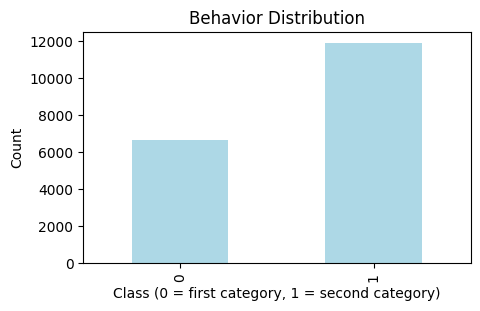


#️⃣The code to each game:
                                  GameName  Code
0                    ARK: Survival Evolved    34
1   Age of Empires IV: Anniversary Edition    41
2                 American Truck Simulator    57
3                            Apex Legends™    89
4                                   Arma 3    61
..                                     ...   ...
95                             War Thunder    56
96                                Warframe    16
97               Warhammer 40000: Darktide    17
98                   Yu-Gi-Oh! Master Duel    55
99            theHunter: Call of the Wild™     7

[100 rows x 2 columns]


In [ ]:
# encoding behavior to 1/0
behavior_encoder = LabelEncoder()
encoded_values1 = behavior_encoder.fit_transform(df_top["Behavior"])
encoded_behavior_df = pd.DataFrame({
    "Behavior": behavior_encoder.classes_,
    "Code": range(len(behavior_encoder.classes_))
})
print('#️⃣The code to each behavior:')
print(encoded_behavior_df)
print('\n🧮The number of elements in each behavior:')
print(df_top["Behavior"].value_counts())
print()

plt.figure(figsize=(5, 3))
pd.Series(encoded_values1).value_counts().sort_index().plot(kind='bar', title="Behavior Distribution", color='lightblue')
plt.xlabel("Class (0 = first category, 1 = second category)")
plt.ylabel("Count")
plt.show()

# encoding game names to numbers
game_encoder = LabelEncoder()
encoded_values2 = game_encoder.fit_transform(df_top["GameName"].unique())
encoded_games_df = pd.DataFrame({
    "GameName": game_encoder.classes_,
    "Code": encoded_values2
})
print('\n#️⃣The code to each game:')
print(encoded_games_df)

## **Normalization 📏**

In [ ]:
# normalization
dense_cols = ["total_play_hours","purchase_count","purchase_ratio","avg_playtime"]
X_dense = user_features[dense_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)
print('Numeric Measures normalized ✅')
pd.DataFrame(X_scaled, columns=dense_cols).describe().loc[['mean','std']]

Numeric Measures normalized ✅


,total_play_hours,purchase_count,purchase_ratio,avg_playtime
mean,1.776449e-17,-1.184300e-16,-4.737198e-17,-2.664674e-17
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00


## **Visualization 📊**

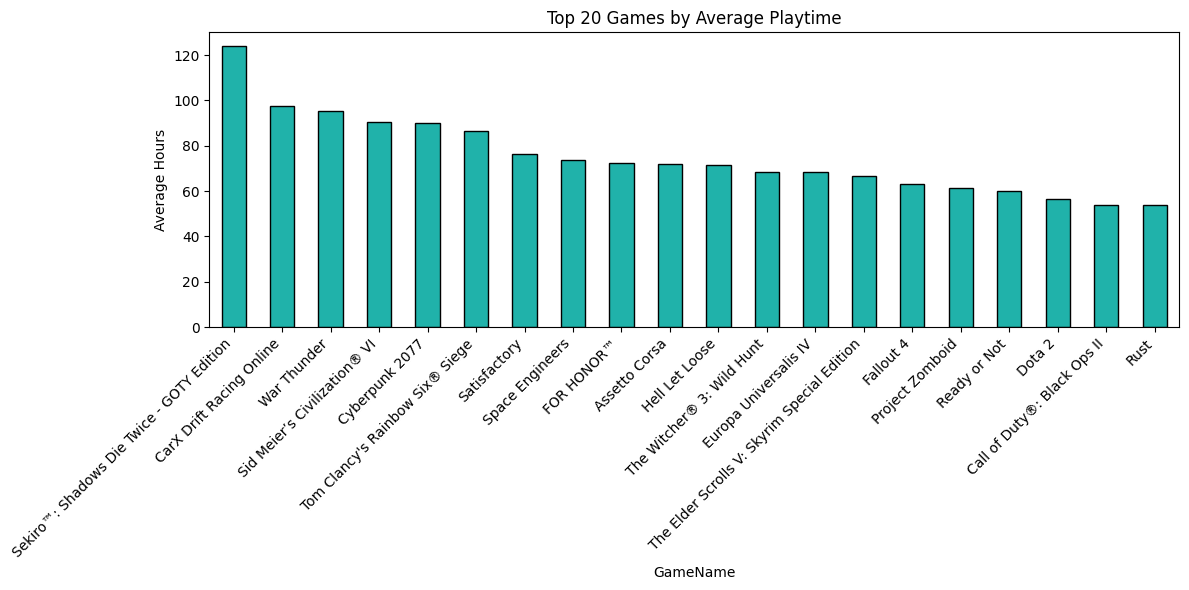

In [ ]:
# histogram showing the avg hours spended on each of the 100 top games

avg_playtime_per_game = (
    df_top[df_top["Behavior"] == "play"]
    .groupby("GameName", observed=True)["Hours"]
    .mean()
    .sort_values(ascending=False)
)

top20_avg = avg_playtime_per_game.head(20)

plt.figure(figsize=(12,6))
top20_avg.plot(kind="bar", color="lightseagreen", edgecolor="black")
plt.title("Top 20 Games by Average Playtime")
plt.ylabel("Average Hours")
plt.xlabel("GameName")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **Unsupervised Clustering ( K-Means )**

## **Finding Number of Clusters 🧩**

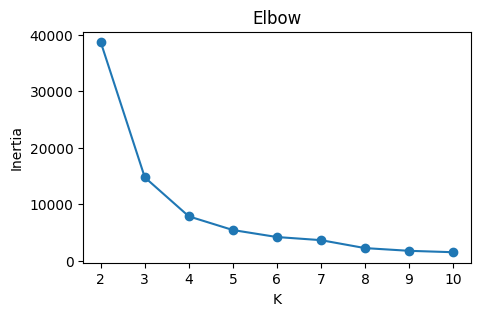

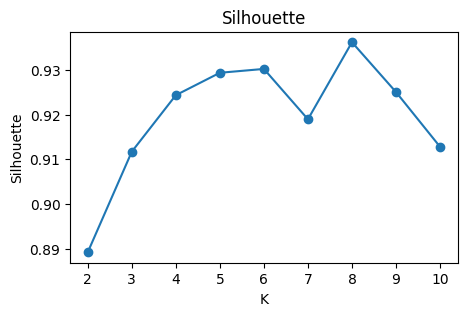

In [ ]:
# num of clusters (elbow + silhouette score)
inertias = []
sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), inertias, marker="o")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.show()

print()

plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), sil_scores, marker="o")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette")
plt.show()

## **KMeans Clustering ⚙️**

In [ ]:
# kmeans
best_k = 4
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
user_features["cluster_km"] = labels_km
print('KMeans Clustering applied with k=4 ✅')
print("✨KMeans silhouette:", silhouette_score(X_scaled, labels_km))
print("📐KMeans DB index:", davies_bouldin_score(X_scaled, labels_km))

KMeans Clustering applied with k=4 ✅
✨KMeans silhouette: 0.9243219323207894
📐KMeans DB index: 0.43600161534540766


## **DBSCAN Clustering 🌌**

In [ ]:
# dbscan
from sklearn.cluster import DBSCAN
for eps in [0.3, 0.5, 0.7, 1.0]:
    db = DBSCAN(eps=eps, min_samples=10)
    db_labels = db.fit_predict(X_scaled)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise = np.sum(db_labels == -1)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled[db_labels!=-1], db_labels[db_labels!=-1])
    else:
        sil = np.nan
    print(f"eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={sil}")

eps=0.3: clusters=8, noise=121, silhouette=0.9247003012748408
eps=0.5: clusters=5, noise=81, silhouette=0.9217871553456086
eps=0.7: clusters=5, noise=71, silhouette=0.9201870974303333
eps=1.0: clusters=4, noise=61, silhouette=0.9171953866971159


In [ ]:
# choose eps that gives reasonable clusters and low noise
db_labels = DBSCAN(eps=0.7, min_samples=10).fit_predict(X_scaled)
user_features["cluster_db"] = db_labels
print('DBSCAN Clustering applied with eps=0.7 ✅')
print('\n⚖️Comparing clusters of km to db:')
print(user_features["cluster_km"].value_counts())
print()
print(user_features["cluster_db"].value_counts())

# showing the cluster each row belongs to (-1 is noise)
print('\n🧩Showing the cluster each row belongs to:')
print(user_features.head())

DBSCAN Clustering applied with eps=0.7 ✅

⚖️Comparing clusters of km to db:
cluster_km
0    12558
1     6445
3      170
2       26
Name: count, dtype: int64

cluster_db
 3    11958
 0     6578
 1      334
 4      236
-1       71
 2       22
Name: count, dtype: int64

🧩Showing the cluster each row belongs to:
   UserID  total_play_hours  purchase_count  total_interactions  avg_playtime  \
0     369               3.3             0.0                   1           3.3   
1    4514               3.2             0.0                   1           3.2   
2    4884               4.7             0.0                   1           4.7   
3    6812               7.0             0.0                   1           7.0   
4    8338               4.0             0.0                   1           4.0   

   unique_genres  unique_categories  purchase_ratio  ARK: Survival Evolved  \
0              1                  1             0.0                    0.0   
1              1                  1            

## **Visualizing Clusters 🧮**

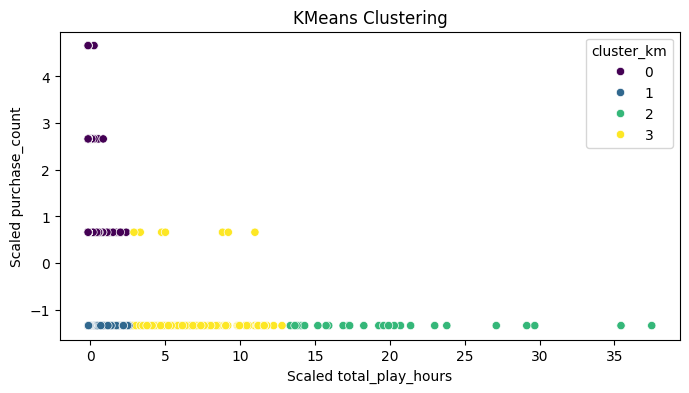

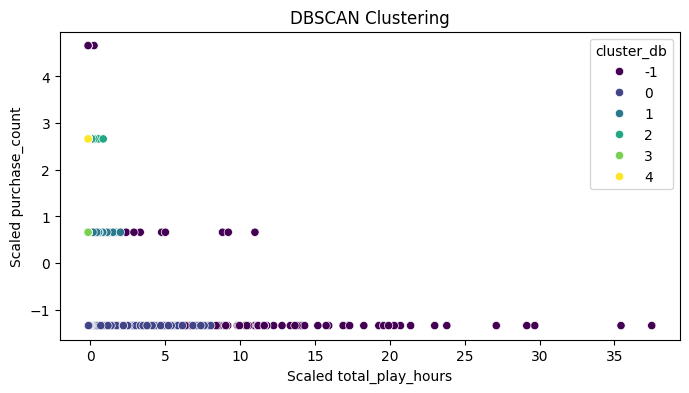

In [ ]:
# Visualize KMeans clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=user_features['cluster_km'], palette='viridis', legend='full')
plt.title('KMeans Clustering')
plt.xlabel('Scaled total_play_hours')
plt.ylabel('Scaled purchase_count')
plt.show()

print()

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=user_features['cluster_db'], palette='viridis', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Scaled total_play_hours')
plt.ylabel('Scaled purchase_count')
plt.show()

## **Outliers Detection 🚨**

🚨 Outliers detected: 1002 values
Lower Bound=-25.40, Upper Bound=45.00
19864    249.0
30959     51.0
64290     67.0
82585     75.0
31183    100.0
Name: Hours, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


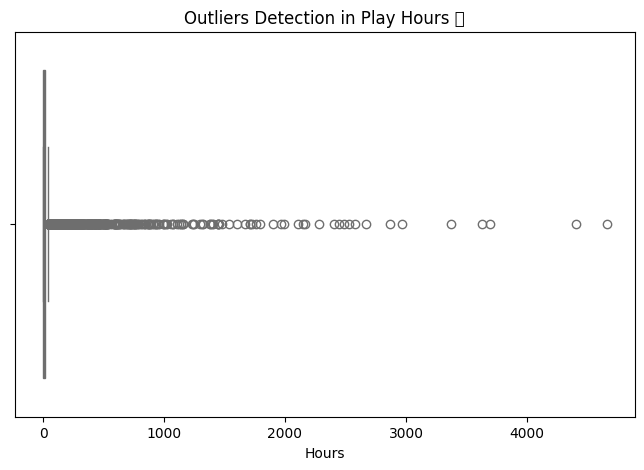

In [ ]:
# outliers detection


hours_play = df[df["Behavior"]=="play"]["Hours"]
Q1, Q3 = np.percentile(hours_play, [25, 75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

outliers = hours_play[(hours_play < lower) | (hours_play > upper)]

print(f"🚨 Outliers detected: {len(outliers)} values")
print(f"Lower Bound={lower:.2f}, Upper Bound={upper:.2f}")
print(outliers.head())

plt.figure(figsize=(8,5))
sns.boxplot(x=hours_play, color="lightcoral")
plt.title("Outliers Detection in Play Hours 🚨")
plt.show()


## **Cluster Profiling 🎯**

📊 Cluster Profiling:
         total_play_hours  purchase_count  total_interactions  avg_playtime  \
Cluster                                                                       
0                    5.67            0.68                1.04          5.58   
1                 1216.12            0.05                1.08       1199.66   
2                 2905.53            0.00                1.00       2905.53   
3                  385.23            0.04                1.07        378.57   

         purchase_ratio  
Cluster                  
0                  0.66  
1                  0.03  
2                  0.00  
3                  0.02  


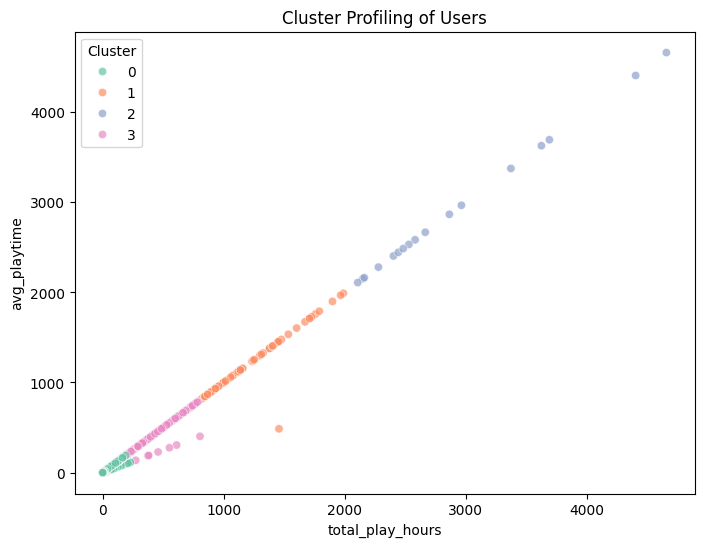

In [ ]:
features = ["total_play_hours", "purchase_count", "total_interactions", "avg_playtime", "purchase_ratio"]
X = stats[features]

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
stats["Cluster"] = kmeans.fit_predict(X)

cluster_profile = stats.groupby("Cluster")[features].mean().round(2)
print("📊 Cluster Profiling:")
print(cluster_profile)

plt.figure(figsize=(8,6))
sns.scatterplot(data=stats, x="total_play_hours", y="avg_playtime", hue="Cluster", palette="Set2", alpha=0.7)
plt.title("Cluster Profiling of Users")
plt.show()

# **Supervised Prediction**


## **Data Splitting for Supervised Learning**

In [ ]:
from sklearn.model_selection import train_test_split

final_df = stats.merge(df[['UserID', 'Behavior']], on='UserID', how='left')

X = final_df.drop(columns=['UserID', 'Behavior'], errors='ignore')
y = final_df['Behavior']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"عدد صفوف بيانات التدريب (X_train): {X_train.shape[0]}")
print(f"عدد صفوف بيانات الاختبار (X_test): {X_test.shape[0]}")

عدد صفوف بيانات التدريب (X_train): 15956
عدد صفوف بيانات الاختبار (X_test): 3990


## **Model training and comparison**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# تهيئة النماذج
log_reg = LogisticRegression(random_state=42, solver='liblinear')
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# تدريب نموذج الانحدار اللوجستي
print("Training Logistic Regression model...")
log_reg.fit(X_train, y_train)
print("✅ تدريب نموذج Logistic Regression اكتمل.")

# تدريب نموذج الغابة العشوائية
print("\nTraining Random Forest model...")
rf_clf.fit(X_train, y_train)
print("✅ تدريب نموذج Random Forest اكتمل.")

Training Logistic Regression model...
✅ تدريب نموذج Logistic Regression اكتمل.

Training Random Forest model...
✅ تدريب نموذج Random Forest اكتمل.


## **Model Evaluation and Comparison**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# الحصول على تنبؤات من نموذج الانحدار اللوجستي
y_pred_log_reg = log_reg.predict(X_test)

# الحصول على تنبؤات من نموذج الغابة العشوائية
y_pred_rf = rf_clf.predict(X_test)

# --- تقييم نموذج الانحدار اللوجستي ---
print("✅ تقييم نموذج الانحدار اللوجستي (Logistic Regression):")
print("\n- تقرير التصنيف:")
print(classification_report(y_test, y_pred_log_reg))
print("\n- مصفوفة الالتباس:")
print(confusion_matrix(y_test, y_pred_log_reg))

# --- تقييم نموذج الغابة العشوائية ---
print("\n\n✅ تقييم نموذج الغابة العشوائية (Random Forest):")
print("\n- تقرير التصنيف:")
print(classification_report(y_test, y_pred_rf))
print("\n- مصفوفة الالتباس:")
print(confusion_matrix(y_test, y_pred_rf))

✅ تقييم نموذج الانحدار اللوجستي (Logistic Regression):

- تقرير التصنيف:
              precision    recall  f1-score   support

        play       0.97      0.98      0.97      1433
    purchase       0.99      0.98      0.98      2557

    accuracy                           0.98      3990
   macro avg       0.98      0.98      0.98      3990
weighted avg       0.98      0.98      0.98      3990


- مصفوفة الالتباس:
[[1399   34]
 [  43 2514]]


✅ تقييم نموذج الغابة العشوائية (Random Forest):

- تقرير التصنيف:
              precision    recall  f1-score   support

        play       0.96      0.96      0.96      1433
    purchase       0.98      0.98      0.98      2557

    accuracy                           0.97      3990
   macro avg       0.97      0.97      0.97      3990
weighted avg       0.97      0.97      0.97      3990


- مصفوفة الالتباس:
[[1374   59]
 [  56 2501]]


#  **Final User Interface (Gradio)**



In [ ]:
import gradio as gr
from sklearn.cluster import KMeans

# --- 1. إعداد البيانات وتدريب النماذج ---
print("✅ جارٍ إعداد البيانات وتدريب النماذج...")

# أ. تحميل البيانات
file_path = 'steamgames_100k_rows.csv'
try:
    df = pd.read_csv(file_path)

    has_genres = 'Genres' in df.columns
    has_categories = 'Categories' in df.columns

    if not has_genres or not has_categories:
        print("⚠️ ملاحظة: ملف CSV الحالي لا يحتوي على أعمدة 'Genres' و 'Categories'.")
        print("سيتم عرض 'Not Available' في التوصيات.")

except FileNotFoundError:
    print("❌ خطأ: لم يتم العثور على الملف. تأكد من أن الملف تم تحميله مباشرة إلى Colab.")
    exit()

# أخذ عينة من البيانات لسرعة المعالجة
# NOTE: Sampling a fraction of the data for prototyping. Remove for full run.
df = df.sample(frac=0.2, random_state=42)

# ب. بناء الخصائص السلوكية للمستخدمين
try:
    playtime = df[df["Behavior"] == "play"].groupby("UserID", observed=True)["Hours"].sum().rename("total_play_hours")
    purchases = df[df["Behavior"] == "purchase"].groupby("UserID", observed=True).size().rename("purchase_count")
    interactions = df.groupby("UserID", observed=True).size().rename("total_interactions")
    avg_play = df[df["Behavior"] == "play"].groupby("UserID", observed=True)["Hours"].mean().rename("avg_playtime")
    stats = pd.concat([playtime, purchases, interactions, avg_play], axis=1).fillna(0).reset_index()
    stats["purchase_ratio"] = (stats["purchase_count"] / stats["total_interactions"].replace(0, np.nan)).fillna(0)
except Exception as e:
    print(f"❌ خطأ: فشل في بناء الخصائص السلوكية. الخطأ: {e}")
    exit()

if stats.empty:
    print("❌ خطأ: لا يوجد أي مستخدمين صالحين في العينة التي تم تحليلها.")
    exit()

# ج. التجميع (Clustering)
try:
    best_k = 4
    dense_cols = ["total_play_hours", "purchase_count", "purchase_ratio", "avg_playtime"]
    X_dense = stats[dense_cols].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_dense)
    kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
    stats['Cluster'] = kmeans.fit_predict(X_scaled)
except Exception as e:
    print(f"❌ خطأ: فشل في عملية التجميع. الخطأ: {e}")
    exit()

# د. التنبؤ (Prediction)
try:
    log_reg = LogisticRegression(random_state=42, solver='liblinear')
    X = stats.drop(columns=['UserID', 'Cluster'])
    y = stats['purchase_ratio'].apply(lambda x: 1 if x > 0 else 0)
    log_reg.fit(X, y)
except Exception as e:
    print(f"❌ خطأ: فشل في تدريب نموذج التنبؤ. الخطاء: {e}")
    exit()

print("✅ تم الإعداد بنجاح. الواجهة جاهزة للتشغيل.")

# --- 2. تعريف الدوال للواجهة التفاعلية ---

def user_profile(uid):
    user_data = stats[stats['UserID'] == uid]
    if user_data.empty:
        return f"**Error:** User {uid} not found."

    cluster_name_map = {0: "اللاعبون المحترفون (Pro Gamers)", 1: "المستخدمون العاديون (Casuals)", 2: "المشترون (Buyers)", 3: "لاعبو الألعاب المجانية (Free-to-Play)"}
    cluster_name = cluster_name_map.get(user_data['Cluster'].iloc[0], "غير معروفة (Unknown)")

    return f"""
<div style='color: #4CAF50; font-size: 1.2em; font-weight: bold;'>👤 User Profile</div>

- **User ID**: {int(uid)}
- **Total Play Hours**: {int(user_data['total_play_hours'].iloc[0])} hours
- **Purchases**: {int(user_data['purchase_count'].iloc[0])}
- **User Type**: {cluster_name}
    """

def purchase_prediction(uid):
    user_data = stats[stats['UserID'] == uid]
    if user_data.empty:
        return f"**Error:** User {uid} not found."

    user_features = user_data.drop(columns=['UserID', 'Cluster'])
    purchase_prob = log_reg.predict_proba(user_features)[0][1]

    prediction_text = "Highly Likely to Buy" if purchase_prob > 0.5 else "Unlikely to Buy"
    purchase_prob_percent = round(purchase_prob * 100, 2)

    return f"""
<div style='color: #4CAF50; font-size: 1.2em; font-weight: bold;'>🔮 Purchase Prediction</div>

- **Prediction**: {prediction_text}
- **Probability**: {purchase_prob_percent}%
    """

def get_recommendations(uid):
    user_data = stats[stats['UserID'] == uid]
    if user_data.empty:
        return "No data found for this user."

    interacted_games = df[df['UserID'] == uid]['GameName'].unique()
    all_games = df['GameName'].unique()
    non_interacted_games = all_games[~np.isin(all_games, interacted_games)]

    if len(non_interacted_games) == 0:
        return "This user has interacted with all available games."

    user_features = user_data.drop(columns=['UserID', 'Cluster'])
    purchase_prob = log_reg.predict_proba(user_features)[0][1]

    recs_df = pd.DataFrame({'GameName': non_interacted_games, 'PurchaseProbability': [purchase_prob] * len(non_interacted_games)})
    recs_df = recs_df.sort_values(by='PurchaseProbability', ascending=False)

    output_html = ""
    cluster_name_map = {0: "Pro Gamers", 1: "Casuals", 2: "Buyers", 3: "Free-to-Play"}
    cluster_name = cluster_name_map.get(user_data['Cluster'].iloc[0], "Unknown")

    has_genres = 'Genres' in df.columns
    has_categories = 'Categories' in df.columns

    for index, row in recs_df.head(5).iterrows():
        prob = row['PurchaseProbability']
        prob_color = "#55d852" if prob > 0.5 else "#F44336"

        game_info = df[df['GameName'] == row['GameName']].iloc[0]
        game_genres = game_info['Genres'] if has_genres else "Not Available"
        game_categories = game_info['Categories'] if has_categories else "Not Available"

        output_html += f"""
        <div class="rec-card" style="
            display: flex;
            align-items: center;
            background-color: #ffffff;
            border: 1px solid #e0e0e0;
            border-radius: 8px;
            box-shadow: 2px 2px 0px #d0d0d0;
            padding: 15px;
            margin-bottom: 15px;
            transition: transform 0.2s;
        ">
            <div class="game-cover" style="
                width: 80px;
                height: 80px;
                background-color: #ddd;
                border: 2px solid #333;
                box-shadow: 3px 3px 0px #999;
                border-radius: 8px;
                margin-right: 15px;
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 40px;
                color: #aaa;
            ">🎮</div>
            <div style="flex-grow: 1;">
                <h3 style="color: #4CAF50; margin: 0 0 5px 0; font-size: 1.1em; font-weight: 600;">{row['GameName']}</h3>
                <p style="color: #666; font-size: 0.9em; margin: 0 0 8px 0;">
                    <span style="color: #999;">🕹️ Genre:</span> {game_genres}
                    <br>
                    <span style="color: #999;">👥 Style:</span> {game_categories}
                </p>
                <div class="progress-container" style="
                    background-color: #ecf0f1;
                    border-radius: 5px;
                    height: 10px;
                    width: 100%;
                    overflow: hidden;
                ">
                    <div class="progress-bar" style="
                        background-color: {prob_color};
                        height: 100%;
                        width: {round(prob * 100)}%;
                    "></div>
                </div>
                <p style="color: #333; margin: 5px 0 0 0; font-size: 0.8em;">**Probability:** <span style="font-weight: bold; color: {prob_color};">{round(prob * 100, 2)}%</span></p>
            </div>
        </div>
        """
    return f"""
    <div style='color: #2c3e50; font-size: 1.5em; font-weight: bold; margin-bottom: 15px;'>🎯 Recommended Games 🎯</h3></div>
    <div>{output_html}</div>
    """

# --- 3. بناء الواجهة باستخدام الدوال المدمجة ---
def run_all(uid):
    profile = user_profile(uid)
    pred = purchase_prediction(uid)
    recs = get_recommendations(uid)

    return profile, pred, recs

poppins_font_url = "https://fonts.googleapis.com/css2?family=Poppins:wght@400;600;700&display=swap"
pixel_font_url = "https://fonts.googleapis.com/css2?family=Press+Start+2P&display=swap"

custom_css = f"""
    @import url('{poppins_font_url}');
    @import url('{pixel_font_url}');

    body {{
        background-color: #f0f2f5;
        color: #2c3e50;
        font-family: 'Poppins', sans-serif;
    }}
    .gr-button.primary {{
        background-color: #34495e;
        border: 2px solid #2c3e50;
        color: #fff;
        transition: all 0.2s;
        cursor: pointer;
    }}
    .gr-button.primary:hover {{
        background-color: #2c3e50;
        border-color: #34495e;
        transform: scale(1.05);
    }}
    .gradio-container {{
        background: #f7f7f7;
        border-radius: 15px;
        box-shadow: 0 10px 25px rgba(0,0,0,0.1);
        padding: 20px;
    }}
    .pixel-header {{
        position: relative;
        background-color: #e6f0f5;
        padding: 30px;
        text-align: center;
        border-radius: 15px 15px 0 0;
        overflow: hidden;
        border-bottom: 3px solid #ccc;
    }}
    .pixel-header::before {{
        content: '';
        position: absolute;
        bottom: 0;
        left: 0;
        width: 100%;
        height: 10px;
        background-color: #d8d8d8;
        z-index: 1;
    }}
    .title-text {{
        font-family: 'Press Start 2P', cursive;
        color: #34495e;
        font-size: 2.5em;
        text-align: center;
        margin-bottom: 0;
        z-index: 3;
        position: relative;
        text-shadow: 2px 2px 0px #bdc3c7;
    }}
    .tabs {{
        background-color: #ecf0f1;
        border-radius: 12px;
        padding: 5px;
        border: 1px solid #bdc3c7;
    }}
    .tab-nav button {{
        background-color: transparent !important;
        border: none !important;
        color: #7f8c8d !important;
        font-family: 'Poppins', sans-serif;
        font-weight: 600;
        transition: transform 0.2s, background-color 0.2s;
    }}
    .tab-nav button:hover {{
        transform: translateY(-2px);
    }}
    .tab-nav button.selected {{
        background-color: #34495e !important;
        border-radius: 8px !important;
        color: #fff !important;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        transform: scale(1.05);
    }}
    .rec-card {{
        background-color: #ffffff;
        border: 1px solid #e0e0e0;
        border-radius: 8px;
        box-shadow: 2px 2px 0px #d0d0d0;
        padding: 15px;
        margin-bottom: 15px;
        transition: transform 0.2s;
    }}
    .rec-card:hover {{
        transform: translateY(-5px);
        box-shadow: 5px 5px 0px #a0a0a0;
    }}
    .progress-container {{
        background-color: #ecf0f1;
        border-radius: 5px;
        height: 10px;
        width: 100%;
        overflow: hidden;
    }}
    .progress-bar {{
        background-color: #34495e;
        height: 100%;
        width: 0%;
    }}
"""

with gr.Blocks(theme=gr.themes.Monochrome(), css=custom_css) as demo:
    with gr.Row():
        with gr.Column():
            gr.HTML("""
                <div class="pixel-header">
                    <h1 class="title-text">ML GAME RECOMMENDATION SYSTEM</h1>
                </div>
            """)

    gr.Markdown("A professional and modern interface to get personalized game recommendations.", elem_classes="emoji-bg")

    valid_uids = [int(u) for u in stats['UserID'].tolist()]
    user_id_input = gr.Dropdown(
        label="Select User ID",
        choices=valid_uids,
        value=valid_uids[0] if valid_uids else None
    )

    run_btn = gr.Button("Get Recommendations", elem_classes="primary")

    with gr.Tabs() as tabs:
        with gr.Tab("👤 User Profile"):
            profile_out = gr.Markdown()

        with gr.Tab("🔮 Prediction"):
            prediction_out = gr.Markdown()

        with gr.Tab("🎯 Recommendations"):
            rec_out = gr.HTML()

    run_btn.click(fn=run_all, inputs=user_id_input, outputs=[profile_out, prediction_out, rec_out])

demo.launch(share=True)

✅ جارٍ إعداد البيانات وتدريب النماذج...
✅ تم الإعداد بنجاح. الواجهة جاهزة للتشغيل.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://751d0ce5d554f9a85f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
